In [1]:
import jax.numpy as jnp
import jax3dp3 as j
import trimesh
import os
import numpy as np
import trimesh
import jax


# --- creating the model dir from the working directory
model_dir = os.path.join(j.utils.get_assets_dir(), "ycb_video_models/models")
print(f"{model_dir} exists: {os.path.exists(model_dir)}")
model_names = j.ycb_loader.MODEL_NAMES
IDX = 13
name = model_names[IDX]
print(name)


bop_ycb_dir = os.path.join(j.utils.get_assets_dir(), "bop/ycbv")
rgbd, gt_ids, gt_poses, masks = j.ycb_loader.get_test_img('52', '1', bop_ycb_dir)
intrinsics = j.Intrinsics(
    height=rgbd.intrinsics.height,
    width=rgbd.intrinsics.width,
    fx=rgbd.intrinsics.fx, fy=rgbd.intrinsics.fx,
    cx=rgbd.intrinsics.width/2.0, cy=rgbd.intrinsics.height/2.0,
    near=0.001, far=2.0
)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
/home/ubuntu/jax3dp3/assets/ycb_video_models/models exists: True
025_mug


In [2]:
import jax3dp3.posecnn_densefusion
densefusion = jax3dp3.posecnn_densefusion.DenseFusion()

/home/ubuntu/jax3dp3/jax3dp3/posecnn-pytorch/PoseCNN-PyTorch
adding /home/ubuntu/jax3dp3/jax3dp3/posecnn-pytorch/PoseCNN-PyTorch/tools/.. to path
adding /home/ubuntu/jax3dp3/jax3dp3/posecnn-pytorch/PoseCNN-PyTorch/tools/../lib to path
adding /home/ubuntu/jax3dp3/jax3dp3/posecnn-pytorch/PoseCNN-PyTorch/tools/../ycb_render to path
ycb_video_train
ycb_video_val
ycb_video_keyframe
ycb_video_trainval
ycb_video_debug
ycb_object_train
ycb_object_test
ycb_self_supervision_train_1
ycb_self_supervision_train_2
ycb_self_supervision_train_3
ycb_self_supervision_train_4
ycb_self_supervision_train_5
ycb_self_supervision_test
ycb_self_supervision_all
ycb_self_supervision_train_block_median
ycb_self_supervision_train_block_median_azure
ycb_self_supervision_train_block_median_demo
ycb_self_supervision_train_block_median_azure_demo
ycb_self_supervision_train_table
ycb_self_supervision_debug
ycb_self_supervision_train_block
ycb_self_supervision_train_block_azure
ycb_self_supervision_train_block_big_sim
y

/home/ubuntu/jax3dp3/jax3dp3/posecnn-pytorch/PoseCNN-PyTorch/tools/../lib/densefusion/transformations.py:1912: UserWarning: failed to import module _transformations
  warnings.warn('failed to import module %s' % name)
/opt/conda/envs/jax/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/envs/jax/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


resetting to seed 100
Called with args:
{'gpu_id': 0, 'pretrained': '/home/ubuntu/jax3dp3/jax3dp3/posecnn-pytorch/PoseCNN-PyTorch/data/trained_checkpoints/posecnn/ycb_object/vgg16_ycb_object_self_supervision_epoch_8.checkpoint.pth', 'cfg_file': '/home/ubuntu/jax3dp3/jax3dp3/posecnn-pytorch/PoseCNN-PyTorch/experiments/cfgs/ycb_object.yml', 'dataset_name': 'ycb_object_test', 'datadir': '/home/ubuntu/jax3dp3/jax3dp3/posecnn-pytorch/PoseCNN-PyTorch/datasets/pandas/data/new_panda/', 'resdir': '/home/ubuntu/jax3dp3/jax3dp3/posecnn-pytorch/PoseCNN-PyTorch/datasets/pandas/data/results_PoseCNN_pandas/', 'network_name': 'posecnn', 'background_name': None, 'meta_file': None, 'pretrained_encoder': None, 'codebook': None}
Using config:
{'ANCHOR_RATIOS': [0.5, 1, 2],
 'ANCHOR_SCALES': [8, 16, 32],
 'BACKGROUND': '',
 'CAD': '',
 'DATA_PATH': '',
 'EPS': 1e-14,
 'EXP_DIR': 'ycb_object',
 'FEATURE_STRIDE': 16,
 'FLIP_X': False,
 'FLOW_HEIGHT': 512,
 'FLOW_WIDTH': 640,
 'GPU_ID': 0,
 'INPUT': 'COLOR',


In [3]:
mesh_path = os.path.join(model_dir,name,"textured.obj")
print(mesh_path)
mesh = j.mesh.load_mesh(mesh_path)

/home/ubuntu/jax3dp3/assets/ycb_video_models/models/025_mug/textured.obj


In [4]:
NUM_IMAGES_PER_ITER = 100
FIXED_TRANSLATION = jnp.array([0.0, 0.08324493, 1.0084537])
_seed = 411
key = jax.random.PRNGKey(_seed)
object_poses = jax.vmap(lambda key: j.distributions.gaussian_vmf(key, 0.00001, 0.001))(
    jax.random.split(key, NUM_IMAGES_PER_ITER)
)
object_poses = object_poses.at[:,:3,3].set(FIXED_TRANSLATION)

In [6]:
## fetch dataset
DATASET_FILENAME = f"dataset_{_seed}_{NUM_IMAGES_PER_ITER}.npz"  # npz file
DATASET_FILE = os.path.join(j.utils.get_assets_dir(), f"datasets/{DATASET_FILENAME}")

load_from_existing = False

# generate and save the dataset
if not load_from_existing:
    rgbds = j.kubric_interface.render_multiobject_parallel([mesh_path], object_poses[None,...],
                                                          intrinsics, scaling_factor=1.0, lighting=1.0) # multi img singleobj
    np.savez(DATASET_FILE, rgbds=rgbds, poses=object_poses, id=IDX, name=model_names[IDX], intrinsics=intrinsics, mesh_path=mesh_path)

# or load preexisting dataset
else:
    data = np.load(DATASET_FILE,allow_pickle=True)
    rgbds = data["rgbds"]
    object_poses = data["poses"]
    id = data["id"].item()

rgb_images = j.hvstack_images([j.get_rgb_image(r.rgb) for r in rgbds], 10, 10)
rgb_images.show()
rgb_images.save(f"dataset_{NUM_IMAGES_PER_ITER}_seed_{_seed}.png")


path:
/home/ubuntu/jax3dp3
sudo docker run --rm --interactive --user $(id -u):$(id -g) --volume /home/ubuntu/jax3dp3:/home/ubuntu/jax3dp3 --volume /tmp:/tmp   --volume /home/ubuntu/jax3dp3/assets/ycb_video_models/models/025_mug:/home/ubuntu/jax3dp3/assets/ycb_video_models/models/025_mug  kubricdockerhub/kubruntu /usr/bin/python3 /home/ubuntu/jax3dp3/jax3dp3/photorealistic_renderers/kubric_exec_parallel.py
['/home/ubuntu/jax3dp3/assets/ycb_video_models/models/025_mug/textured.obj']
POSES: [[[array([0.        , 0.08324493, 1.0084537 ], dtype=float32)
   array([ 0.69697225, -0.6824363 , -0.08155759, -0.20459467], dtype=float32)]]

 [[array([0.        , 0.08324493, 1.0084537 ], dtype=float32)
   array([-0.64083433,  0.6842656 ,  0.3466262 ,  0.03101879], dtype=float32)]]

 [[array([0.        , 0.08324493, 1.0084537 ], dtype=float32)
   array([-0.578581  , -0.01208678,  0.80970234,  0.0973669 ], dtype=float32)]]

 [[array([0.        , 0.08324493, 1.0084537 ], dtype=float32)
   array([-0.457

In [ ]:
# run densefusion on dataset
all_results = []
for scene_idx, rgbd in enumerate(rgbds):
    results = densefusion.get_densefusion_results(rgbd.rgb, rgbd.depth, rgbd.intrinsics, scene_name=str(scene_idx))
    all_results.extend(results)

import pickle
with open(f"dataset_{NUM_IMAGES_PER_ITER}_seed_{_seed}.pkl", 'wb') as f:
    pickle.dump(all_results, f)

{'025_mug': {'class_id': 14, 'rot_q': array([0.53187892, 0.79012462, 0.09136719, 0.29061992]), 'tr': array([0.00688948, 0.08131116, 1.00822863])}}


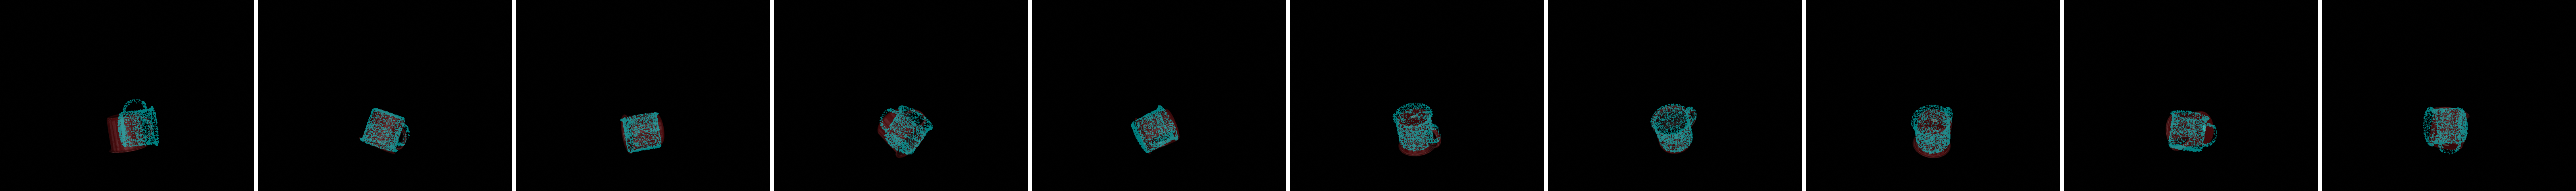

In [ ]:
## Visualize densefusion outputs

from PIL import Image

VIZ_DIR = os.path.join(os.getcwd(), "Densefusion_iterative_result/")

densefusion_vizs = []

for scene_idx, _ in enumerate(rgbds):
    im = Image.open(os.path.join(VIZ_DIR, f"{scene_idx}.png"))
    densefusion_vizs.append(im)
densefusion_result_viz = j.hvstack_images(densefusion_vizs, 10, 10)
densefusion_result_viz.show()

In [ ]:
rgb_images.show()  # original dataset for comparison